In [1]:
from dataloader import PositiveDataset, NegativeDataset, SlidingWindowDataset
from models import rHoG, hard_example_mining_svm
from torch.utils.data import ConcatDataset, DataLoader
import numpy as np
from metric import det_curve_fppw, plot_det_curves
from sklearn.svm import SVC, LinearSVC

Prepare datasets

In [2]:
positive_dataset = PositiveDataset("data/INRIAPerson/train_64x128_H96/pos")
negative_dataset = NegativeDataset("data/INRIAPerson/train_64x128_H96/neg")
train_dataset = ConcatDataset([positive_dataset, negative_dataset])
data_loader = DataLoader(train_dataset, batch_size=len(train_dataset))
for batch in data_loader:
    train_data = batch[0].numpy()
    train_label = batch[1].numpy()
print("Train data shape:", train_data.shape)

positive_dataset = PositiveDataset("data/INRIAPerson/test_64x128_H96/pos")
negative_dataset = NegativeDataset("data/INRIAPerson/test_64x128_H96/neg",num_patches=15)
test_dataset = ConcatDataset([positive_dataset, negative_dataset])
data_loader = DataLoader(test_dataset, batch_size=len(test_dataset))
for batch in data_loader:
    test_data = batch[0].numpy()
    test_label = batch[1].numpy()
print("Test data shape:", test_data.shape)

Train data shape: (11536, 3, 128, 64)
Test data shape: (5626, 3, 128, 64)


1. Comparison on orientations

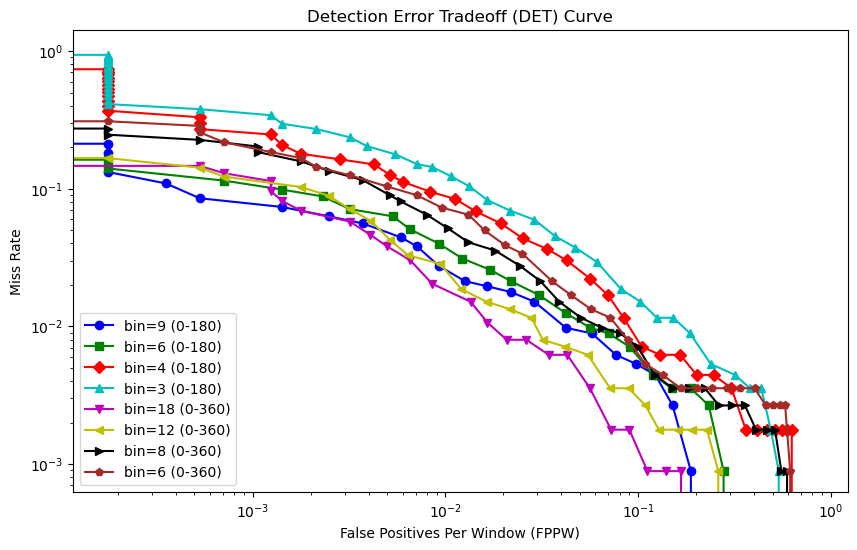

In [3]:
names = ['bin=9 (0-180)', 'bin=6 (0-180)','bin=4 (0-180)','bin=3 (0-180)',
         'bin=18 (0-360)','bin=12 (0-360)','bin=8 (0-360)','bin=6 (0-360)']

hogs = [rHoG(nbins=9), rHoG(nbins=6), rHoG(nbins=4), rHoG(nbins=3), 
       rHoG(nbins=18, signed_gradient=True),
       rHoG(nbins=12, signed_gradient=True),
       rHoG(nbins=8, signed_gradient=True),
       rHoG(nbins=6, signed_gradient=True)]

fppws = []
miss_rates = []
ex1 = LinearSVC(C=0.01)

for hog in hogs:
    ex1 = hard_example_mining_svm(ex1, hog(train_data), train_label)
    scores = ex1.decision_function(hog(test_data))
    miss, fppw = det_curve_fppw(test_label, scores)
    fppws.append(fppw)
    miss_rates.append(miss)

plot_det_curves(names, fppws, miss_rates)

2. SVM Kernel

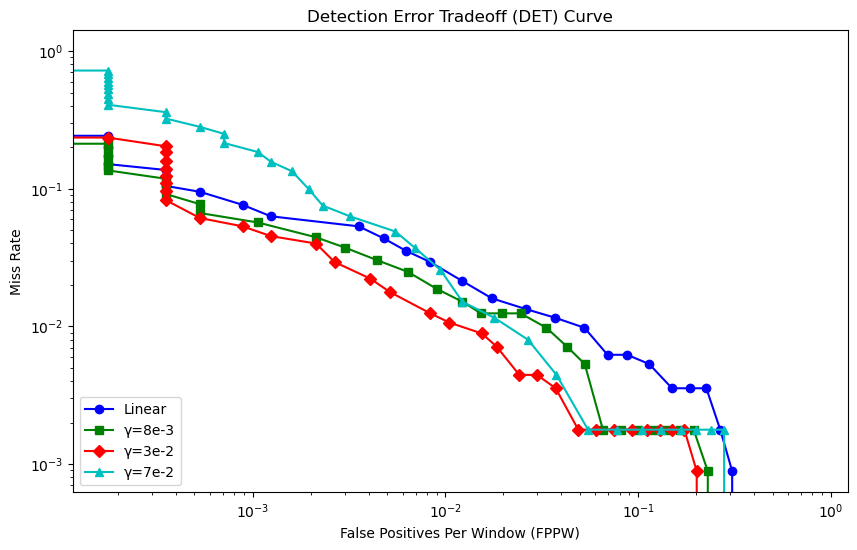

In [4]:
names = ['Linear', 'γ=8e-3', 'γ=3e-2', 'γ=7e-2']
hog2 = rHoG()
inpt1 = hog2(train_data)
inpt2 = hog2(test_data)

svms = [SVC(kernel='linear', C=0.01), 
        SVC(kernel='rbf', gamma=8e-3),
        SVC(kernel='rbf', gamma=3e-2),
        SVC(kernel='rbf', gamma=7e-2)]

fppws = []
miss_rates = []

for model in svms:
    m = hard_example_mining_svm(model, inpt1, train_label)
    scores = m.decision_function(inpt2)
    miss, fppw = det_curve_fppw(test_label, scores)
    fppws.append(fppw)
    miss_rates.append(miss)

plot_det_curves(names, fppws, miss_rates)

3. window size

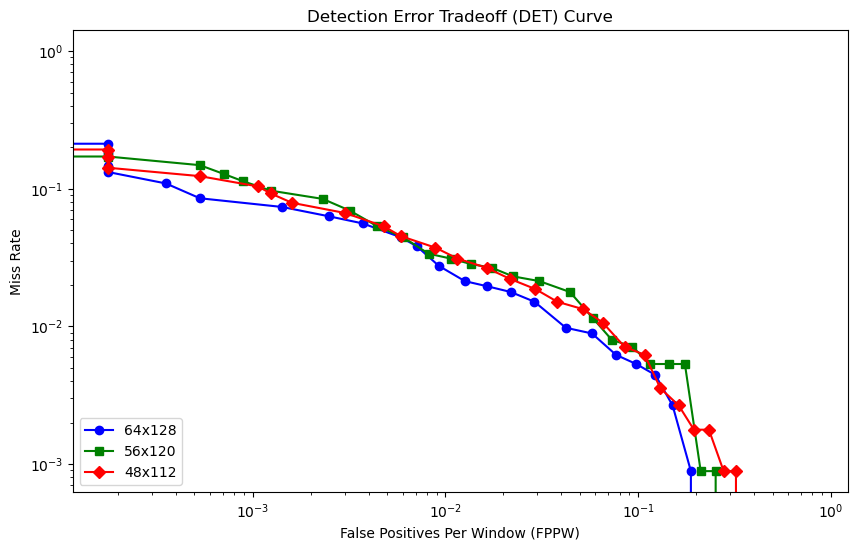

In [6]:
names = ['64x128','56x120','48x112']
hogs = [rHoG(win_size=(64,128)),rHoG(win_size=(56,120)),rHoG(win_size=(48,112))]
trains = [train_data, train_data[:,:,4:-4,4:-4], train_data[:,:,8:-8,8:-8]]
tests = [test_data, test_data[:,:,4:-4,4:-4], test_data[:,:,8:-8,8:-8]]
ex3 = LinearSVC(C=0.01)
fppws = []
miss_rates = []

for hog, train, test in zip(hogs, trains, tests):
    ex3 = hard_example_mining_svm(ex3, hog(train), train_label)
    scores = ex3.decision_function(hog(test))
    miss, fppw = det_curve_fppw(test_label, scores)
    fppws.append(fppw)
    miss_rates.append(miss)
    
plot_det_curves(names, fppws, miss_rates)

4. overlap

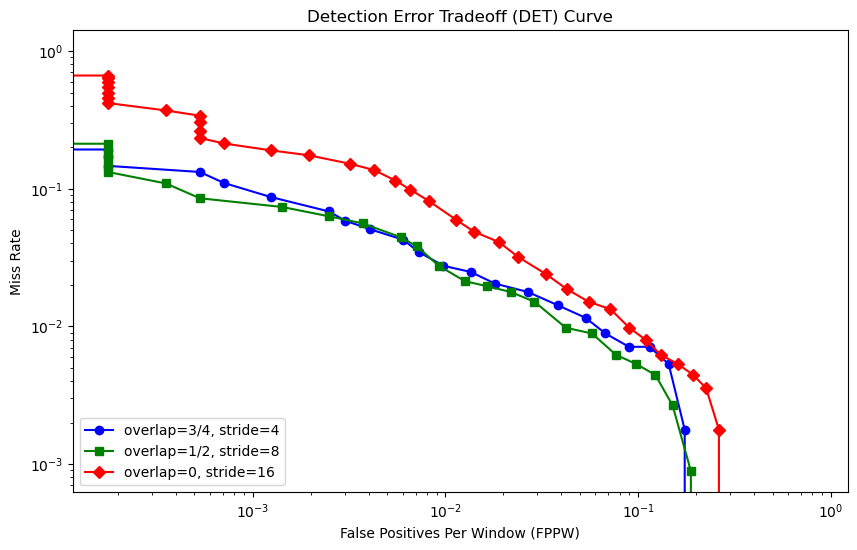

In [7]:
names = ['overlap=3/4, stride=4','overlap=1/2, stride=8','overlap=0, stride=16']
fppws = []
miss_rates = []
ex4 = LinearSVC(C=0.01)
hogs = [rHoG(stride=(4,4)),rHoG(),rHoG(stride=(16, 16))]

for hog in hogs:
    ex4 = hard_example_mining_svm(ex4, hog(train_data), train_label)
    scores = ex4.decision_function(hog(test_data))
    miss, fppw = det_curve_fppw(test_label, scores)
    fppws.append(fppw)
    miss_rates.append(miss)

plot_det_curves(names, fppws, miss_rates)

5. gauss smooth

(11536, 3, 128, 64)
(11536, 3, 128, 64)
(11536, 3, 128, 64)
(11536, 3, 128, 64)
(11536, 3, 128, 64)


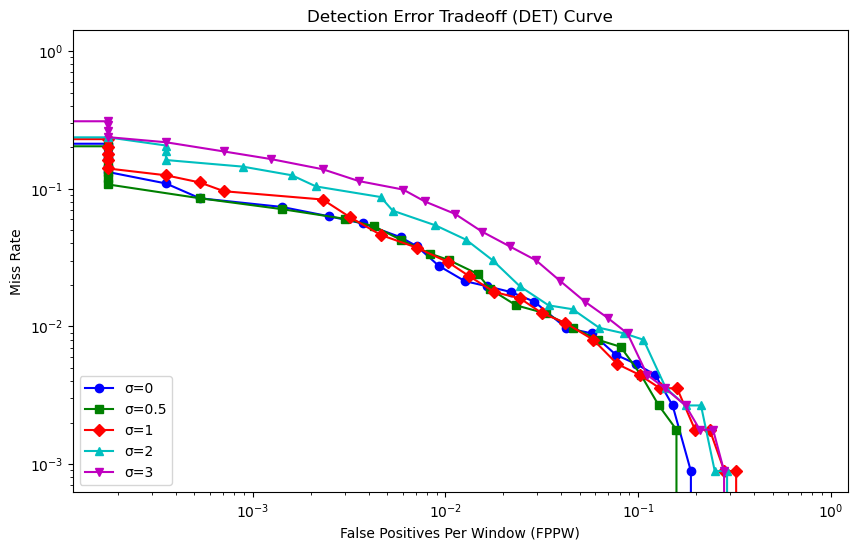

In [11]:
from cv2 import GaussianBlur
def gauss_filter(imgs, sigma):
    if sigma == 0:
        return imgs
    output = []
    ksize = int(2 * round(3 * sigma) + 1)
    for img in imgs:
        image_smooth = GaussianBlur(img.transpose([0,1,2]), (ksize, ksize), sigma)
        output.append(image_smooth)
    return np.array(output)

names = ['σ=0','σ=0.5','σ=1','σ=2','σ=3']
fppws = []
miss_rates = []
ex5 = LinearSVC(C=0.01)
hog5  = rHoG()
sigmas = [0, 0.5, 1, 2, 3]
for sig in sigmas:
    inpt = gauss_filter(train_data, sig)
    print(inpt.shape)
    ex5 = hard_example_mining_svm(ex5, hog5(inpt), train_label)
    inpt2 = gauss_filter(test_data, sig)
    scores = ex5.decision_function(hog5(inpt2))
    miss, fppw = det_curve_fppw(test_label, scores)
    fppws.append(fppw)
    miss_rates.append(miss)

plot_det_curves(names, fppws, miss_rates)

6. normalize

(11536, 3780) (5626, 3780)
(11536, 3780) (5626, 3780)
(11536, 3780) (5626, 3780)
(11536, 3780) (5626, 3780)
(11536, 3780) (5626, 3780)


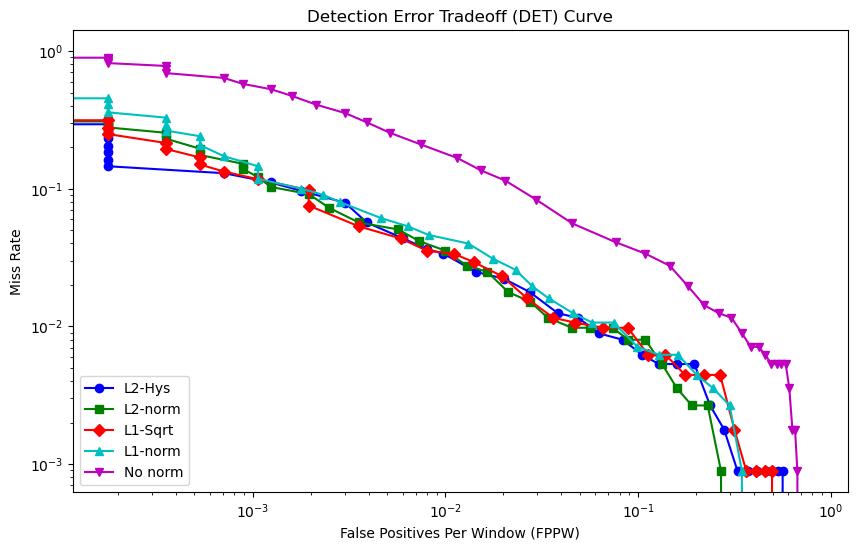

In [12]:
from skimage.feature import hog as HG
def hog_norm(imags, type):
    hog_features = []
    for img in imags:
        features = []
        for c in img:
            f = HG(c,cells_per_block=(2, 2),
                   block_norm=type,)
            features.append(f)
        features = np.max(np.array(features), axis=0)
        hog_features.append(features)
    return np.array(hog_features)

names = ['L2-Hys','L2-norm','L1-Sqrt','L1-norm','No norm']
types = [ 'L2-Hys', 'L2', 'L1-sqrt','L1','none']
fppws = []
miss_rates = []
ex6 = LinearSVC(C=0.01)
for t in types:
    inpt1 = hog_norm(train_data, t)
    inpt2 = hog_norm(test_data, t)
    print(inpt1.shape, inpt2.shape)
    ex6 = hard_example_mining_svm(ex6, inpt1, train_label)
    scores = ex6.decision_function(inpt2)
    miss, fppw = det_curve_fppw(test_label, scores)
    fppws.append(fppw)
    miss_rates.append(miss)

plot_det_curves(names, fppws, miss_rates)